In [3]:
import pandas as pd
from datetime import datetime
import sys
import matplotlib.pyplot as plt
from IPython.display import Image, HTML

In [13]:
import arcgis
from arcgis.gis import GIS
from arcgis.raster.functions import apply, clip, remap, colormap
from arcgis.geometry import lengths, areas_and_lengths, project, Point, Polyline, Polygon, Geometry
from arcgis.geocoding import geocode
from arcgis.features import FeatureLayer

In [14]:
gis = GIS()
nyc = gis.map('New York City')
nyc

MapView(layout=Layout(height='400px', width='100%'))

In [15]:
landsat_item = gis.content.search('title:Multispectral Landsat', 'Imagery Layer', outside_org=True)[0]
landsat = landsat_item.layers[0]
landsat_item

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri>

### NYC spatial data from ny.gov

In [17]:
nyc_fl = FeatureLayer('https://gisservices.its.ny.gov/arcgis/rest/services/NYS_Civil_Boundaries/FeatureServer/4')
ny_df = pd.DataFrame.spatial.from_layer(nyc_fl)
nyc_df = ny_df.iloc[32:33]
nyc_df

,OBJECTID,NAME,MUNI_TYPE,MUNITYCODE,COUNTY,GNIS_ID,FIPS_CODE,SWIS,POP1990,POP2000,POP2010,POP2020,DOS_LL,DOSLL_DATE,MAP_SYMBOL,CALC_SQ_MI,DATEMOD,SHAPE
32,33,New York,city,1,"New York, Bronx, Kings, Richmond, Queens",2395220,3608151000,650000,7322564,8008278,8175133,8804190,None,NaT,3,470.316754,2019-10-04,"{""rings"": [[[-8222688.7686, 4997925.7896], [-8..."


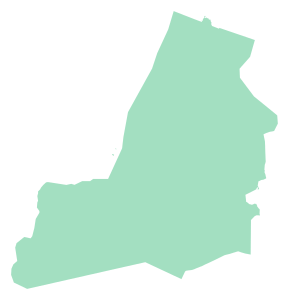

In [18]:
display(nyc_df.spatial)

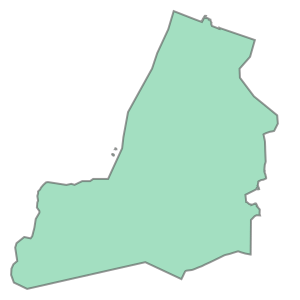

In [19]:
area = geocode('New York City', out_sr=landsat.properties.spatialReference)[0]
landsat.extent = area['extent']

nyc_poly = nyc_df.iloc[0].SHAPE
type(nyc_poly)
display(nyc_poly)

### Landsat image of NYC

In [21]:
selected = landsat.filter_by(where='(Category = 1) AND (cloudcover <= 0.05)',
                             time=[datetime(2022, 5, 24), datetime(2022, 7, 24)],
                             geometry=arcgis.geometry.filters.intersects(area['extent']))

df  = selected.query(out_fields='AcquisitionDate, GroupName, Cloudcover, DayOfYear', order_by_fields='AcquisitionDate').sdf
df['AcquisitionDate'] = pd.to_datetime(df['AcquisitionDate'], unit='ms')
df

,OBJECTID,AcquisitionDate,GroupName,CloudCover,DayOfYear,SHAPE
0,3688901,2022-07-04 15:39:20,LC09_L1TP_014031_20220704_20220705_02_T1_MTL,0.0202,31,"{""rings"": [[[-8135671.1949000005, 5219570.6582..."
1,3688902,2022-07-04 15:39:44,LC09_L1TP_014032_20220704_20220705_02_T1_MTL,0.0326,32,"{""rings"": [[[-8219865.9120000005, 4893190.2289..."
2,3710084,2022-07-20 15:39:23,LC09_L1TP_014031_20220720_20220720_02_T1_MTL,0.0145,31,"{""rings"": [[[-8133231.919299999, 5219572.86069..."
3,3710085,2022-07-20 15:39:46,LC09_L1TP_014032_20220720_20220720_02_T1_MTL,0.0367,32,"{""rings"": [[[-8188346.928300001, 5007472.08929..."


In [22]:
nyc_image = landsat.filter_by('OBJECTID=3710085')

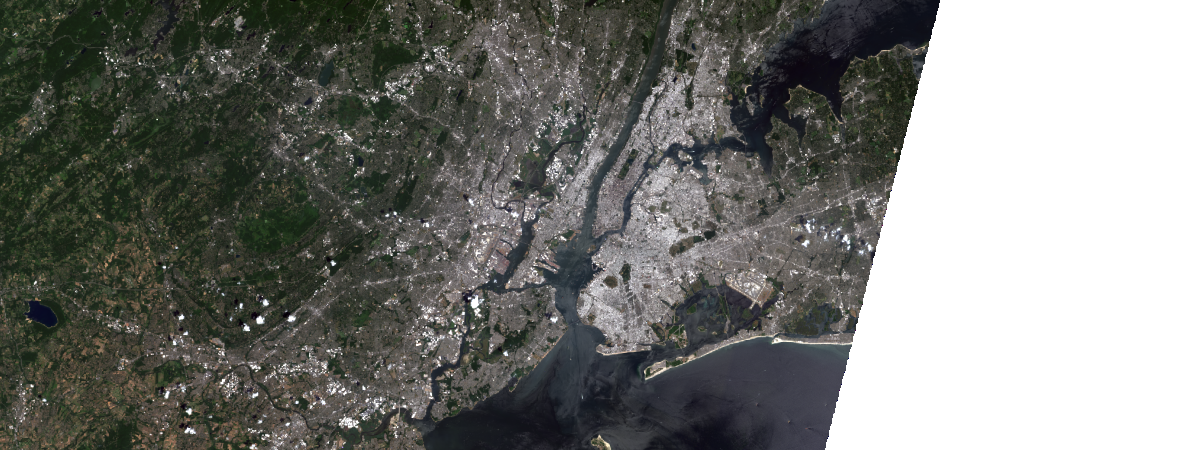

In [23]:
apply(nyc_image, 'Natural Color with DRA')

In [24]:
nyc_colorized = apply(nyc_image, 'NDVI Raw')

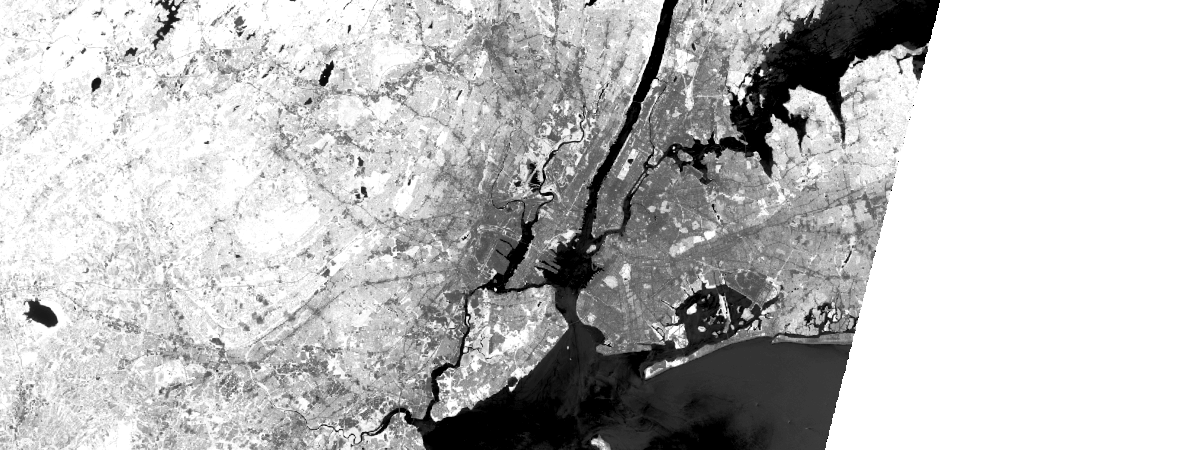

In [25]:
nyc_colorized

### NYC City boundaries

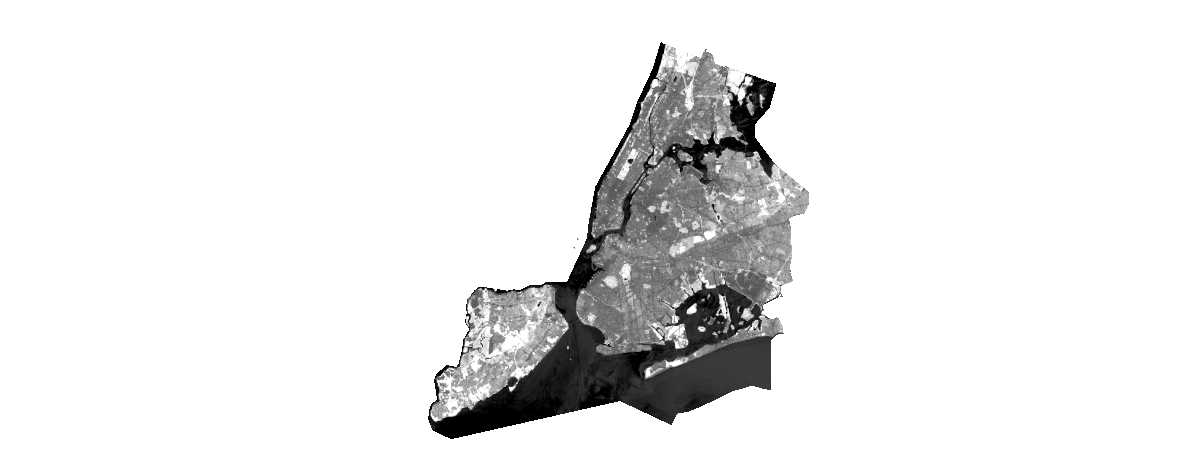

In [26]:
nyc_clip = clip(nyc_colorized, nyc_poly)
nyc_clip.extent = area['extent']
nyc_clip

### NDVI color mask

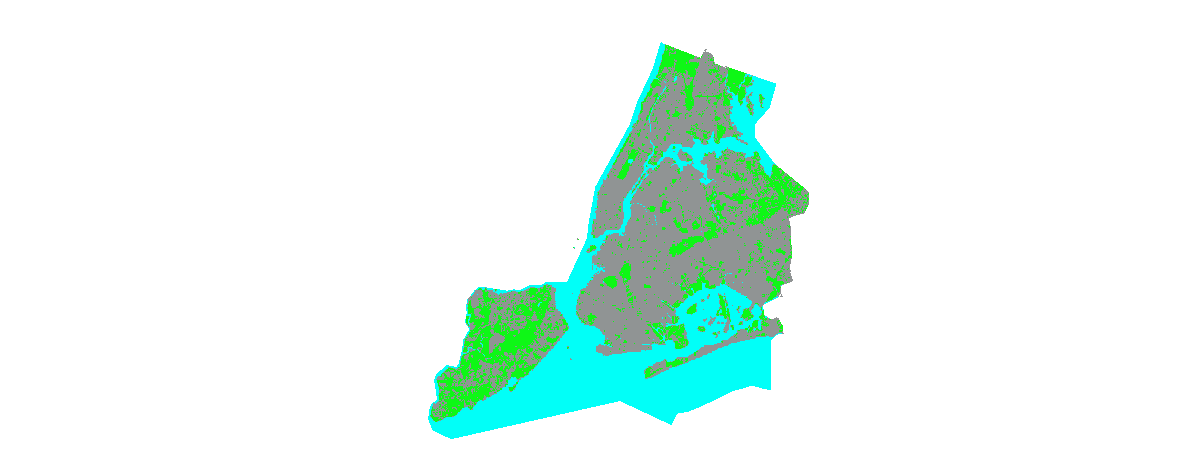

In [27]:
masked  = colormap(remap(nyc_clip,
                         input_ranges=[-1, 0,     # water
                                       -0.1, 0.4, # Concrete
                                       0.4, 1],   # Vegetation, Trees
                         output_values=[1, 2, 3]),
                  colormap=[[1, 1, 255, 248], [2, 144, 148, 148], [3, 14, 247, 22]], astype='u8')

Image(masked.export_image(bbox=area['extent'], size=[1200, 450], f='image'))

In [28]:
mask_map = gis.map('New York City')
mask_map.add_layer(masked)
mask_map

MapView(layout=Layout(height='400px', width='100%'))

### Landcover Analysis

In [32]:
xpixel = (nyc_clip.extent['xmax'] - nyc_clip.extent['xmin']) / 800
ypixel = (nyc_clip.extent['ymax'] - nyc_clip.extent['ymin']) / 400

full_res = masked.compute_histograms(nyc_clip.extent, pixel_size={'x': xpixel, 'y': ypixel})

total_pix = 0
hist = full_res['histograms'][0]['counts'][0:]
for x in hist[1:]:
    total_pix += x
hist

[0, 57446, 73007, 28584]

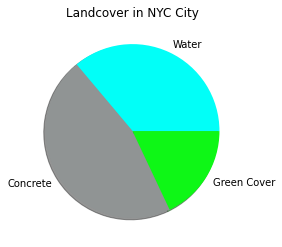

In [34]:
colors=['#0EF716','#01FFF8','#909494']
labels =[ (hist[1]/sum(hist)), (hist[2]/sum(hist)), (hist[3]/sum(hist)) ]

plt.pie(hist, labels=['', 'Water', 'Concrete', 'Green Cover'], colors=colors, shadow=True)
plt.title('Landcover in NYC City')
plt.show()

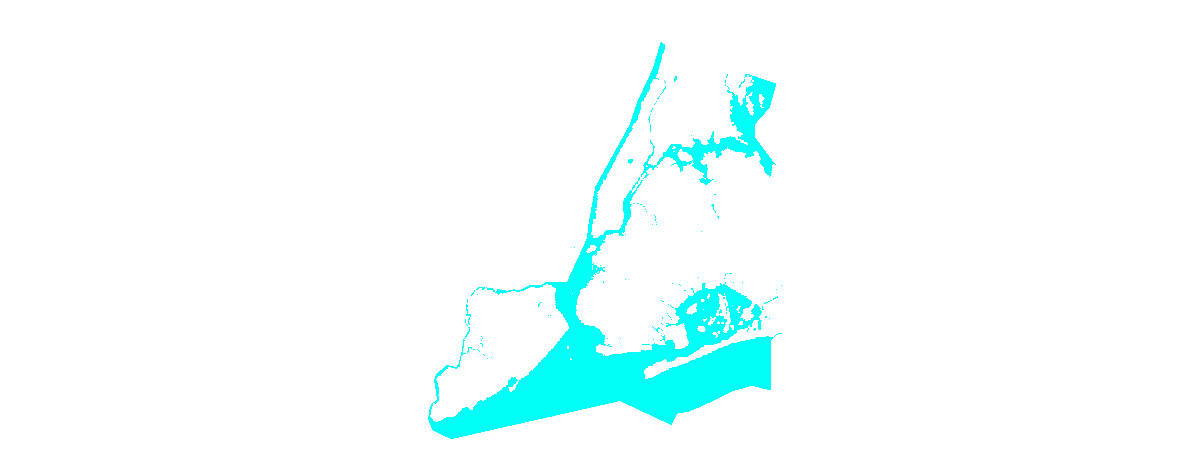

In [35]:
masked_water = colormap(remap(nyc_clip, 
                        input_ranges=[-1,0,     # water
                                     -0.1, 0.4, # Concrete
                                     0.4, 1],   # Vegetation, Trees      
                        output_values=[1, 2, 3]),
                        colormap=[[1, 1, 255, 248], [2, 255, 255, 255], [3,255,255,255]], astype='u8')

Image(masked_water.export_image(bbox=area['extent'], size=[1200,450], f='image'))

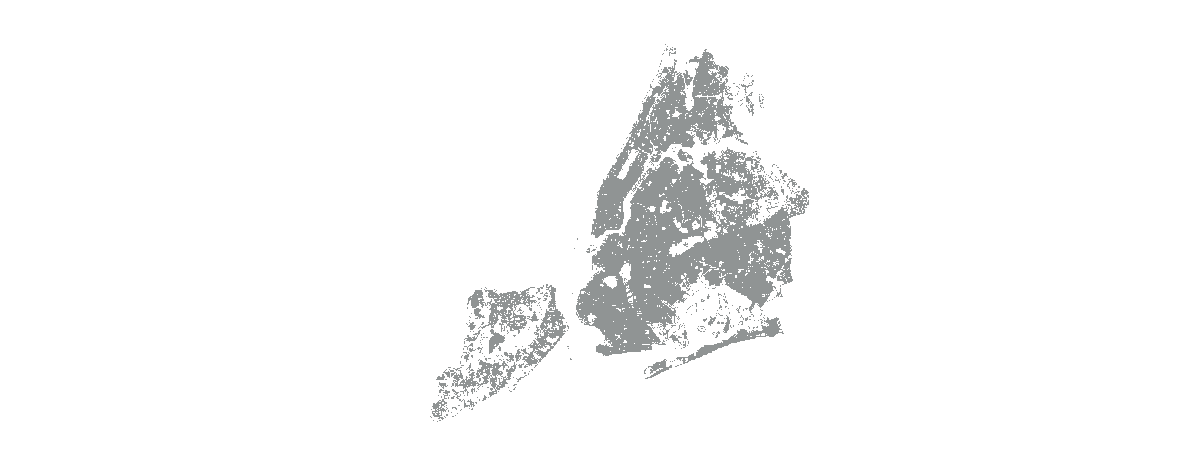

In [36]:
masked_concrete = colormap(remap(nyc_clip, 
                        input_ranges=[-1,0,     # water
                                     -0.1, 0.4, # Concrete
                                     0.4, 1],   # Vegetation, Trees      
                        output_values=[1, 2, 3]),
                        colormap=[[1, 255, 255, 255], [2, 144, 148, 148], [3,255,255,255]], astype='u8')

Image(masked_concrete.export_image(bbox=area['extent'], size=[1200,450], f='image'))

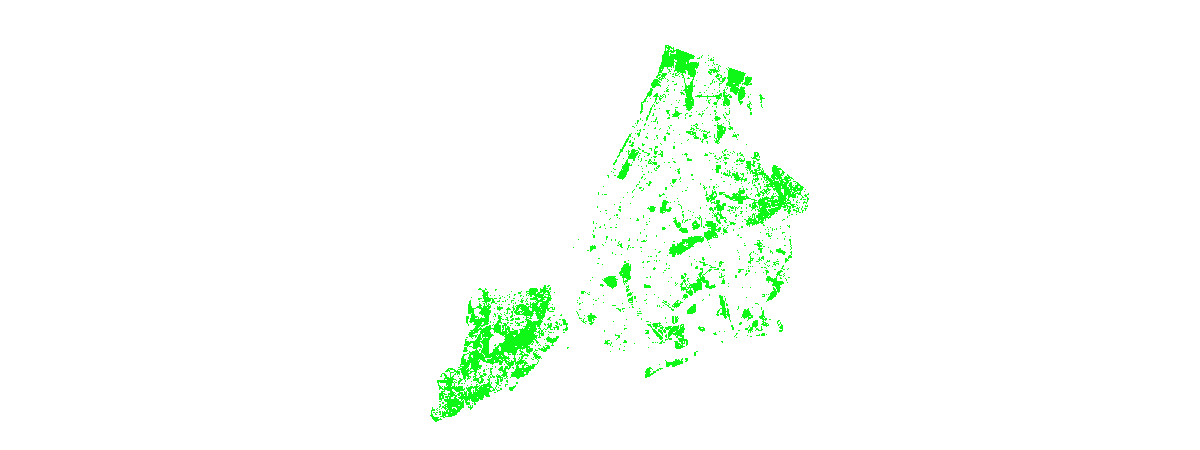

In [40]:
masked_green = colormap(remap(nyc_clip, 
                        input_ranges=[-1,0,     # water
                                     -0.1, 0.4, # Concrete
                                     0.4, 1],   # Vegetation, Trees      
                        output_values=[1, 2, 3]),
                        colormap=[[1, 255, 255, 255], [2,255,255,255], [3, 14, 247, 22]], astype='u8')

Image(masked_green.export_image(bbox=area['extent'], size=[1200,450], f='image'))